In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def evaluate_ae(result, field, printR=False):
    result = result.dropna()
    mae = mean_absolute_error(result[field], result['Lake_Level'])
    msq = mean_squared_error(result[field], result['Lake_Level'])
    if printR:
        print('   MAE: {}'.format(mae))
        print('   RMAE: {}'.format(msq))
    return (field, mae, msq)

In [3]:
df_raw = pd.read_csv('./data/00_original/Lake_Bilancino.csv', sep=',', header=0)

# df = df_raw[['Date', 'Rainfall_Cavallina', 'Temperature_Le_Croci', 'Flow_Rate', 'Lake_Level']].copy()
df = df_raw[['Date', 'Lake_Level']].copy()

df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
df.set_index(['Date'], inplace=True)
df = df.asfreq('D')
df = df.dropna()

df['Lake_Level'] -= (251 - 31)

df

,Lake_Level
Date,
2002-06-03,29.43
2002-06-04,29.43
2002-06-05,29.43
2002-06-06,29.43
2002-06-07,29.44
...,...
2020-06-26,30.85
2020-06-27,30.84
2020-06-28,30.83


In [4]:
# predict 1 day in advance
df1 = df.copy()
df1['yesterday'] = df1['Lake_Level'].shift(1)
df1['last_week'] = df1['Lake_Level'].shift(7)
df1['last_month'] = df1['Lake_Level'].shift(30)
df1['last_year'] = df1['Lake_Level'].shift(365)

df1['avg_last_2D'] = df1['Lake_Level'].rolling(2).mean()
df1['avg_last_3D'] = df1['Lake_Level'].rolling(3).mean()
df1['avg_last_7D'] = df1['Lake_Level'].rolling(7).mean()
df1['avg_last_14D'] = df1['Lake_Level'].rolling(15).mean()
df1['avg_last_31D'] = df1['Lake_Level'].rolling(31).mean()

df1

,Lake_Level,yesterday,last_week,last_month,last_year,avg_last_2D,avg_last_3D,avg_last_7D,avg_last_14D,avg_last_31D
Date,,,,,,,,,,
2002-06-03,29.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-04,29.43,29.43,NaN,NaN,NaN,29.430,NaN,NaN,NaN,NaN
2002-06-05,29.43,29.43,NaN,NaN,NaN,29.430,29.430000,NaN,NaN,NaN
2002-06-06,29.43,29.43,NaN,NaN,NaN,29.430,29.430000,NaN,NaN,NaN
2002-06-07,29.44,29.43,NaN,NaN,NaN,29.435,29.433333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-06-26,30.85,30.87,30.92,31.00,31.62,30.860,30.860000,30.868571,30.899333,30.945484
2020-06-27,30.84,30.85,30.90,30.98,31.62,30.845,30.853333,30.860000,30.892667,30.940323
2020-06-28,30.83,30.84,30.88,30.98,31.61,30.835,30.840000,30.852857,30.885333,30.935484


<AxesSubplot:xlabel='Date'>

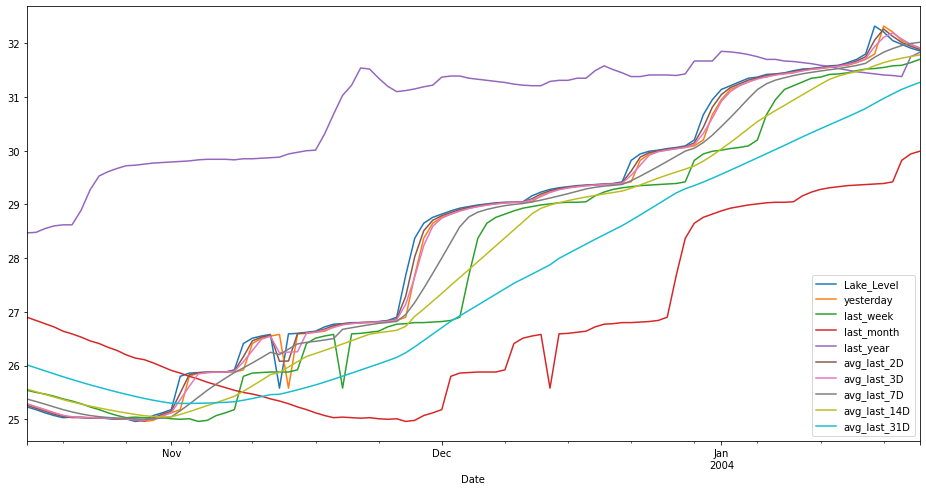

In [5]:
df1[500:600].plot(figsize=(16, 8))

In [6]:
results = []

for c in df1:
    if c != 'Lake_Level':
        results.append(evaluate_ae(df1, c))

df_r = pd.DataFrame(results, columns=['name', 'mae', 'rmae'])
df_r = df_r.set_index('name')

df_r = df_r.sort_values(by=['mae'])

df_r

,mae,rmae
name,,
avg_last_2D,0.023027,0.002788
avg_last_3D,0.044156,0.008323
yesterday,0.046055,0.011152
avg_last_7D,0.119118,0.044675
avg_last_14D,0.246935,0.151705
last_week,0.267698,0.199285
avg_last_31D,0.474413,0.462845
last_month,0.918969,1.626078
last_year,1.598945,5.389600


<AxesSubplot:xlabel='name'>

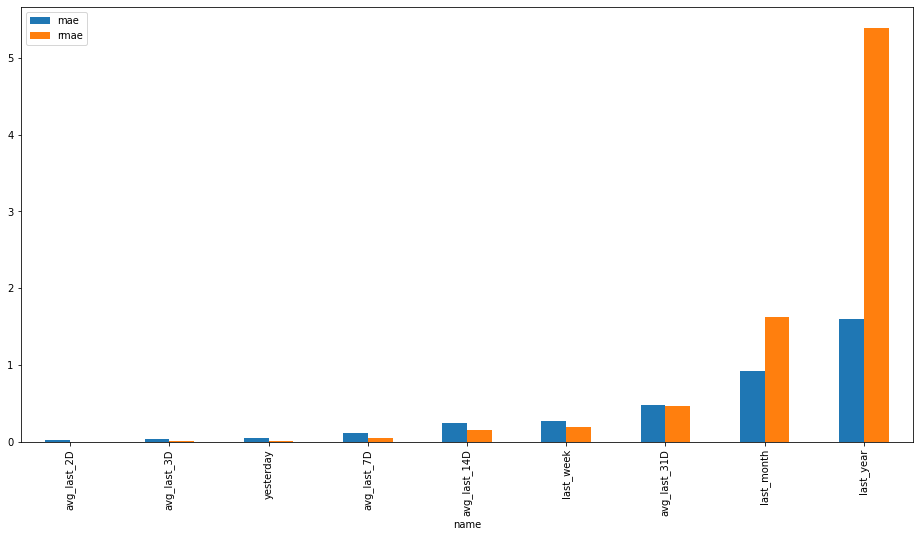

In [7]:
df_r.plot(kind='bar', figsize=(16, 8))

In [100]:
def rolling_forecast(df, interval, fun, printR=True):
    iterations = range(interval, len(df), interval)
    all_forecasts = pd.DataFrame()
    all_forecasts.name = 'TEST'
    
    for index, split in enumerate(iterations):    
        print('Processing iteration: {}/{}'.format(index + 1, len(iterations)), end='\r')        
        learn = df[:split]
        test = df[split:split+interval]
            
        fun_res = fun(learn, interval)
        
        predictions = pd.DataFrame({
            'Lake_Level': test['Lake_Level'],
            'Prediction': fun_res[0:len(test['Lake_Level'])]
        })        
        all_forecasts = all_forecasts.append(predictions)
    
    evaluate = evaluate_ae(all_forecasts, 'Prediction', printR)
    if printR:
        all_forecasts.plot(figsize=(16, 8))
    
    return (all_forecasts, evaluate[1], evaluate[2])

In [130]:
def next_D(learn, interval):
    v = learn['Lake_Level'][-1]
    return [v] * interval

scenarios = []

for future_range in range(1, 15, 2):
    for past_range in range(1, 15, 2):      
        
        def predictionF(learn, interval):
            back = past_range
            if len(learn['Lake_Level']) < past_range: back = len(learn['Lake_Level'])
            v = learn['Lake_Level'][-back].mean()
            return [v] * interval
    
        # next N days will be same as mean from past M days
        r2 = rolling_forecast(df,  future_range, predictionF, False)
        scenarios.append([past_range, future_range , r2[0], r2[1], r2[2]])

scenarios = sorted(scenarios, key=lambda l: l[3])

In [137]:
df_r2 = [['pst_{}_fut_{}'.format(s[0], s[1]), s[0], s[1],  s[3], s[4]] for s in scenarios]

df_r2 = pd.DataFrame(df_r2, columns=['name', 'past', 'future', 'mae', 'rmae'])
df_r2 = df_r2.set_index('name')

print(df_r2.head(5))
print(df_r2.tail(5))

             past  future       mae      rmae
name                                         
pst_1_fut_1     1       1  0.045494  0.010861
pst_1_fut_3     1       3  0.084400  0.033841
pst_1_fut_5     1       5  0.121613  0.062717
pst_3_fut_1     3       1  0.124920  0.057175
pst_1_fut_7     1       7  0.155688  0.089327
               past  future       mae      rmae
name                                           
pst_13_fut_7     13       7  0.528619  0.630279
pst_13_fut_9     13       9  0.555637  0.692137
pst_11_fut_13    11      13  0.557997  0.725863
pst_13_fut_11    13      11  0.585466  0.758155
pst_13_fut_13    13      13  0.608604  0.817583


<AxesSubplot:xlabel='name'>

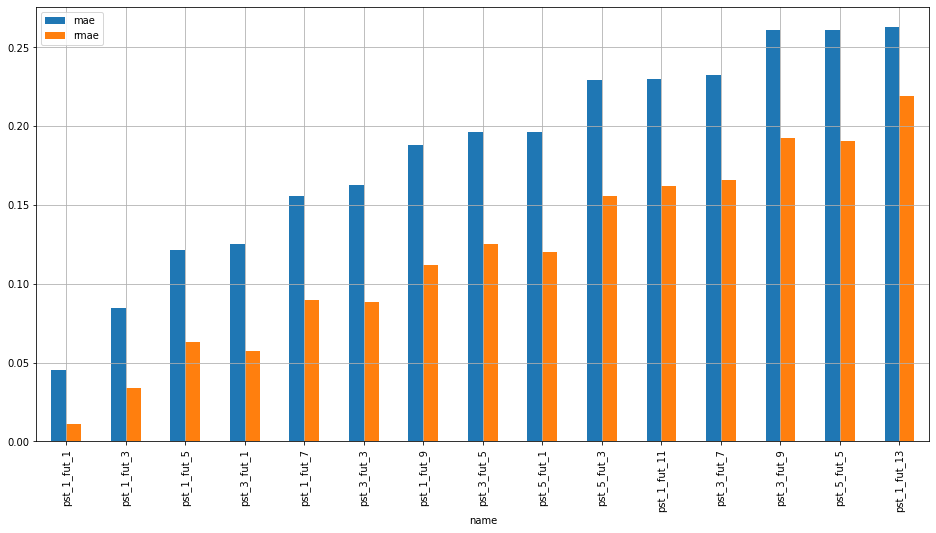

In [143]:
df_r2.iloc[0:15, [2, 3]].plot(kind='bar', figsize=(16, 8), grid=True)